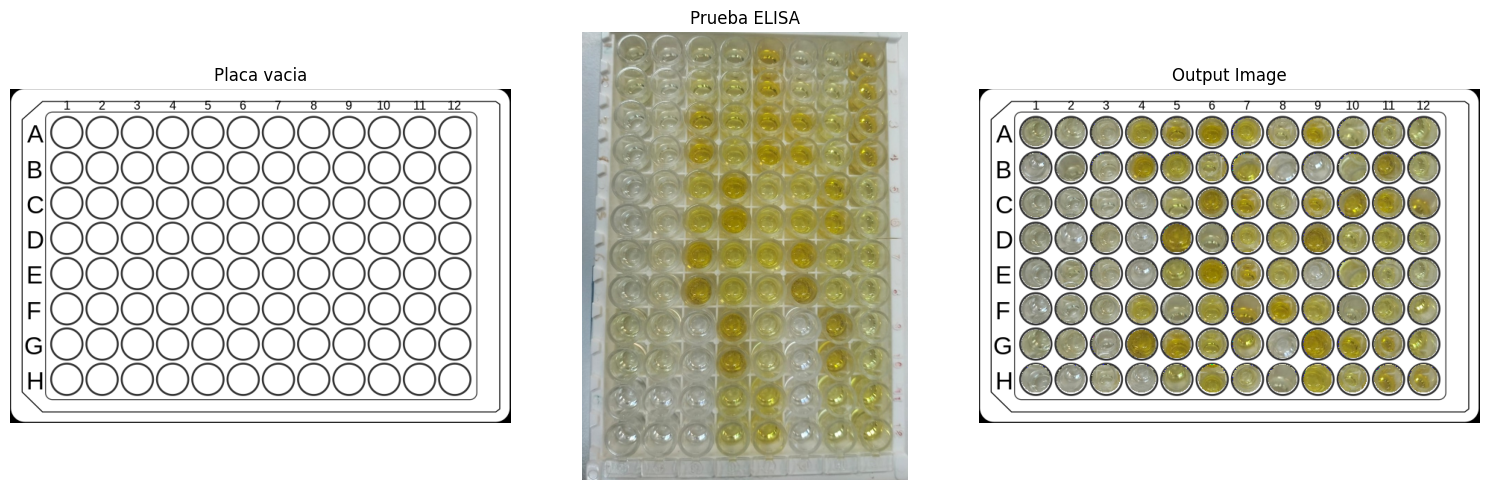

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_circles(image_path, minDist, param1, param2, minRadius, maxRadius, rotate = False):
    img = cv2.imread(image_path)
    if rotate == True:
        img = cv2.transpose(img)
        img = cv2.flip(img, flipCode=0)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=minDist, param1=param1, param2=param2, minRadius=minRadius, maxRadius=maxRadius)
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
    return img, circles

img1, circles1 = get_circles("placa_vacia.png", 10, 50, 40, 18, 20)
img2, circles2 = get_circles("prueba.jpeg", 63, 50, 31, 30, 60, rotate = False)

# Ordenar por coordenada X
circles1 = circles1[circles1[:,0].argsort()]
circles2 = circles2[circles2[:,0].argsort()]

output = img1.copy()

for circle1, circle2 in zip(circles1, circles2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2

    crop_img2 = img2[y2-r2:y2+r2, x2-r2:x2+r2]

    # Create a circular mask with the same size as the cropped image
    mask = np.zeros((2*r2, 2*r2), dtype=np.uint8)
    cv2.circle(mask, (r2, r2), r2, 255, -1)

    # Resize the mask to match the circle in the first image
    resized_mask = cv2.resize(mask, (2*r1, 2*r1))

    # Resize the cropped image to match the circle in the first image
    resized_crop_img2 = cv2.resize(crop_img2, (2*r1, 2*r1))

    # Apply the mask to the resized cropped image
    masked_crop_img2 = cv2.bitwise_and(resized_crop_img2, resized_crop_img2, mask=resized_mask)

    # Cut a hole in the output image to accommodate the new circle
    output[y1-r1:y1+r1, x1-r1:x1+r1] = output[y1-r1:y1+r1, x1-r1:x1+r1] * (1 - resized_mask // 255)[:,:,None]

    # Paste the masked resized cropped image into the output image
    output[y1-r1:y1+r1, x1-r1:x1+r1] += masked_crop_img2
    
    
# Convert images from BGR to RGB for plotting
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img1_rgb)
axes[0].set_title("Placa vacia")
axes[0].axis("off")

axes[1].imshow(img2_rgb)
axes[1].set_title("Prueba ELISA")
axes[1].axis("off")

axes[2].imshow(output_rgb)
axes[2].set_title("Output Image")
axes[2].axis("off")

plt.tight_layout()
plt.show()


In [6]:
# Crear un diccionario para almacenar las etiquetas de los círculos
etiquetas = {}
global_circle_coords = circles1.tolist()

# Asegurar que los círculos estén ordenados en filas
sorted_circles = sorted(circles1, key=lambda x: (x[1], x[0]))

# Asignar un ID único a cada círculo
circle_id_to_coords = {i + 1: coord for i, coord in enumerate(sorted_circles)}

# Función para etiquetar manualmente los círculos
def etiquetar_circulos(event, x, y, flags, param):
    global etiquetas, output, global_circle_coords
    
    for circle_id, (x_center, y_center, radius) in circle_id_to_coords.items():

        distance_from_center = ((x - x_center)**2 + (y - y_center)**2)**0.5
        if distance_from_center <= radius:
            
            if event == cv2.EVENT_LBUTTONDOWN:
                etiquetas[circle_id] = "positivo"
                cv2.circle(output, (x_center, y_center), radius, (0, 255, 0), 2)
                
            elif event == cv2.EVENT_RBUTTONDOWN:
                etiquetas[circle_id] = "negativo"
                cv2.circle(output, (x_center, y_center), radius, (0, 0, 255), 2)

            # Rompe el bucle ya que encontramos el círculo
            break
        
# Configurar la función de manejo de eventos de la ventana
cv2.namedWindow("Etiquetado de círculos")
cv2.setMouseCallback("Etiquetado de círculos", etiquetar_circulos)

# Esperar a que el usuario etiquete todos los círculos
while True:
    cv2.imshow("Etiquetado de círculos", output)
    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):  # Presionar 'q' para salir del bucle
        break

cv2.destroyAllWindows()

# Imprimir las etiquetas
for circle_id, label in etiquetas.items():
    x, y, _ = circle_id_to_coords[circle_id]
    print(f"Círculo ID {circle_id} en ({x}, {y}): {label}")

Círculo ID 1 en (76, 59): negativo
Círculo ID 2 en (123, 59): negativo
Círculo ID 3 en (170, 59): negativo
Círculo ID 4 en (218, 59): positivo
Círculo ID 5 en (265, 59): positivo
Círculo ID 6 en (313, 59): positivo
Círculo ID 7 en (359, 59): positivo
Círculo ID 8 en (407, 59): negativo
Círculo ID 9 en (454, 59): positivo
Círculo ID 10 en (501, 59): negativo
Círculo ID 11 en (549, 59): negativo
Círculo ID 12 en (596, 59): negativo
Círculo ID 13 en (76, 106): negativo
Círculo ID 14 en (123, 106): negativo
Círculo ID 15 en (170, 106): negativo
Círculo ID 16 en (218, 106): positivo
Círculo ID 17 en (265, 106): positivo
Círculo ID 18 en (313, 106): negativo
Círculo ID 19 en (359, 106): positivo
Círculo ID 20 en (407, 106): negativo
Círculo ID 21 en (454, 106): negativo
Círculo ID 22 en (501, 106): negativo
Círculo ID 23 en (549, 106): positivo
Círculo ID 24 en (596, 106): negativo
Círculo ID 25 en (76, 154): negativo
Círculo ID 26 en (123, 154): negativo
Círculo ID 27 en (170, 154): negativ

In [8]:
import pandas as pd

data_list = []

# Para cada círculo etiquetado:
for circle_id, label in etiquetas.items():
    x, y, radius = circle_id_to_coords[circle_id]

    # Crea una máscara circular para el círculo actual
    mascara_circulo = np.zeros(output.shape[:2], dtype=np.uint8)
    cv2.circle(mascara_circulo, (x, y), radius, 255, -1)
    
    # Convierte la imagen de salida (output) a HSV
    img_hsv = cv2.cvtColor(output, cv2.COLOR_BGR2HSV)

    # Extrae los píxeles dentro del círculo usando la máscara
    masked_img_hsv = cv2.bitwise_and(img_hsv, img_hsv, mask=mascara_circulo)
    pixels_hsv = masked_img_hsv[mascara_circulo == 255]

    # Separa los canales
    h_channel = pixels_hsv[:, 0]
    s_channel = pixels_hsv[:, 1]
    v_channel = pixels_hsv[:, 2]

    # Calcula características
    h_mean, h_std = np.mean(h_channel), np.std(h_channel)
    s_mean, s_std = np.mean(s_channel), np.std(s_channel)
    v_mean, v_std = np.mean(v_channel), np.std(v_channel)
    percentiles = np.percentile(pixels_hsv, [25, 50, 75]) 

    # Almacena en un diccionario
    data_dict = {
        'Label': label,
        'H_mean': h_mean,
        'H_std' : h_std,
        'S_mean': s_mean,
        'S_std' : s_std,
        'V_mean': v_mean,
        'V_std' : v_std,
        '25th Percentile': percentiles[0],
        '50th Percentile': percentiles[1],
        '75th Percentile': percentiles[2],
    }

    # Añade a la lista
    data_list.append(data_dict)

# Crea un DataFrame de Pandas
df = pd.DataFrame(data_list)
df.to_csv('data_fasciola.csv', index=False)
df

,Label,H_mean,H_std,S_mean,S_std,V_mean,V_std,25th Percentile,50th Percentile,75th Percentile
0,negativo,26.684677,10.923510,86.264836,68.862154,160.402126,40.818024,32.0,60.0,143.0
1,negativo,26.689991,10.963887,78.019486,71.918796,170.426926,36.599431,33.0,51.0,153.0
2,negativo,25.129318,10.321541,79.994686,71.156983,169.694420,36.526263,30.0,53.0,153.0
3,positivo,31.796280,11.406925,164.899911,48.516848,165.536758,37.583574,28.0,143.0,166.0
4,positivo,30.804252,11.816869,161.867139,56.136728,166.802480,38.105175,27.0,136.0,166.0
...,...,...,...,...,...,...,...,...,...,...
91,negativo,25.007086,10.286504,81.029229,70.521153,165.537644,38.277628,30.0,54.0,148.0
92,positivo,31.814880,11.382796,190.798051,29.650129,170.810452,35.600498,28.0,155.0,182.0
93,negativo,24.331267,9.880334,126.635075,56.592162,171.248007,35.700314,29.0,112.0,156.0
94,positivo,30.507529,11.934950,153.060230,56.211261,168.514615,37.503233,27.0,136.0,163.0


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

features = df.drop(columns=['Label'])  # Elimina la columna de etiquetas para obtener sólo características
labels = df['Label']

# 1. Dividir los datos
# Dado que tienes 96 datos, vamos a utilizar el 80% para entrenamiento y el 20% para prueba
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# 2. Preparar los datos
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Estandarizar los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 3. Crear un modelo con bootstrapping
n_iterations = 1000  # Número de muestras bootstrap
stats = []

for i in range(n_iterations):
    X_resample, y_resample = resample(X_train, y_train_encoded)  # Muestreo con reemplazo
    model = LogisticRegression()
    model.fit(X_resample, y_resample)
    y_pred_probs = model.predict_proba(X_test)[:, 1]  # Probabilidades de la clase positiva
    y_pred = model.predict(X_test)  # Predicciones de clase
    accuracy = accuracy_score(y_test_encoded, y_pred)
    auc = roc_auc_score(y_test_encoded, y_pred_probs)  # Usa probabilidades aquí
    stats.append((accuracy, auc))

# 4. Evaluar el modelo
accuracies, aucs = zip(*stats)
print(f"Accuracy (mean): {np.mean(accuracies):.3f}")
print(f"Accuracy (std): {np.std(accuracies):.3f}")
print(f"AUC (mean): {np.mean(aucs):.3f}")
print(f"AUC (std): {np.std(aucs):.3f}")

# También puedes imprimir un reporte completo de clasificación para una de las iteraciones
print(classification_report(y_test_encoded, y_pred))

# 5. Evaluación de la importancia de características
importance = model.coef_[0]
for i, j in enumerate(importance):
    print(f"Característica: {features.columns[i]}, Importancia: {j:.3f}")


Accuracy (mean): 0.998
Accuracy (std): 0.009
AUC (mean): 1.000
AUC (std): 0.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

Característica: H_mean, Importancia: 1.861
Característica: H_std, Importancia: -0.259
Característica: S_mean, Importancia: 0.960
Característica: S_std, Importancia: -0.670
Característica: V_mean, Importancia: -0.210
Característica: V_std, Importancia: -0.008
Característica: 25th Percentile, Importancia: -0.382
Característica: 50th Percentile, Importancia: 1.005
Característica: 75th Percentile, Importancia: 0.429
